In [1]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as Data
from tqdm import tqdm

import numpy as np
import json

USE_CUDA = True

In [2]:
def readfile(data):
    with open(data, "r", encoding="utf-8") as f:
        content = f.read().splitlines()
        
    return content

def schema_load(schema_root):
    raw_dict = "".join(readfile(schema_root))
    dict2json = "".join(raw_dict.split()[2:])

    json_acceptable_string = dict2json.replace("'", "\"")
    schema = json.loads(json_acceptable_string)
    
    return schema

def define_entity(schema):
    tag_type = list(schema['tagging'])
    
    entity_tag = []
    for k in list(schema['entity'].keys()):
        entity_tag.append(schema['entity'][k]['tag'])
        
    TAG = []
    for t in tag_type:
        for e in entity_tag:
            if t!='O':
                TAG.append(t+'-'+e)  
                
    TAG = [UNKOWN_TAG, PAD_TAG] + TAG + ['O']   

    return TAG

def tag2ix(TAG):
    tag_to_ix={t:i for i,t in enumerate(TAG)}
    return tag_to_ix

def define_relation(schema):
    relation_type = list(schema['relation'])
    
    relation_tag = []
    for k in list(schema['relation'].keys()):
        relation_tag.append(schema['relation'][k]['tag'])
    
    relation_tag = [REL_PAD] + [REL_NONE] + relation_tag
        
    return relation_tag

# ==================================================

def get_word_and_label(_content, start_w, end_w):
    word_list = []
    ent_list = []
    rel_list = []
    
    for word_set in _content[start_w:end_w]:
        word_set = word_set.split()
        if len(word_set)==1:
            word_list.append(' ')
            ent_list.append('O')
            rel_list.append(REL_NONE)
        
        else:
            word_list.append(word_set[0])
            ent_list.append(word_set[1])

            try:
                testerror = word_set[2]
            except IndexError:
                rel_list.append(REL_NONE)
            else:
                rel_list.append(word_set[2:])
    
    return word_list, ent_list, rel_list

def split_to_list(content):
    init = 0
    word_list = []
    ent_list = []
    rel_list = []

    for now_token, c in enumerate(content):
        if c=='':
            words, ents, rels = get_word_and_label(content, init, now_token)
            init = now_token+1
            word_list.append(words)
            ent_list.append(ents)
            rel_list.append(rels)
            
    return word_list, ent_list, rel_list

# ==================================================

def word2index(word_list):
    word_to_ix = {"<UNKNOWN>":0, "<PAD>":1}
    for sentence in word_list:
        for word in sentence:
            if word not in word_to_ix:
                word_to_ix[word] = len(word_to_ix)
                
    return word_to_ix

def dict_inverse(tag_to_ix):
    ix_to_tag = {v: k for k, v in tag_to_ix.items()}
    return ix_to_tag

def index2tag(indexs, ix_to):
    to_tags = [ix_to[i] for i in indexs.cpu().numpy()]
    return to_tags

# ==================================================

def find_max_len(word_list):
    max_len = 0
    for i in range(len(word_list)):
        if max_len<len(word_list[i]):
            max_len=len(word_list[i])
            
    return max_len

# ====== filter the length of sentence more than MAX_LEN =======

def filter_len(word_list):
    reserved_index = []
    for i in range(len(word_list)):
        if len(word_list[i])<MAX_LEN:
            reserved_index.append(i)
            
    return reserved_index


def filter_sentence(reserved_index, word_list, ent_list, rel_list):
    filter_word = list(word_list[i] for i in reserved_index)
    filter_ent = list(ent_list[i] for i in reserved_index)
    filter_rel = list(rel_list[i] for i in reserved_index)
    return filter_word, filter_ent, filter_rel

# ==================================================

def pad_seq(seq, isrel):
    if isrel:
        seq += [REL_NONE for i in range(MAX_LEN-len(seq))]
    else:
        seq += [PAD_TAG for i in range(MAX_LEN-len(seq))]
    return seq

def pad_all(filter_word, filter_ent, filter_rel):
    input_padded = [pad_seq(s, False) for s in filter_word]
    ent_padded = [pad_seq(s, False) for s in filter_ent]
    rel_padded = [pad_seq(s, True) for s in filter_rel]
    
    return input_padded, ent_padded, rel_padded

# ==================================================

def prepare_sequence(seq, to_ix):
    idxs = []
    for w in seq:
        if w not in to_ix:
            idxs.append(to_ix[UNKOWN_TAG])
        else:
            idxs.append(to_ix[w])
    
#     idxs = [to_ix[w] for w in seq]
    return torch.tensor(idxs, dtype=torch.long)

def prepare_all(seqs, to_ix):
    seq_list = []
    for i in range(len(seqs)):
        seq_list.append(prepare_sequence(seqs[i], to_ix))
        
    seq_list = torch.stack(seq_list)
        
    return seq_list



def prepare_rel(rel_padded, to_ix):
    
    rel_ptr = torch.zeros(len(rel_padded), MAX_LEN, MAX_LEN, dtype=torch.long) 
    
    # 對當前的token，去比較之前所有出現過的entity，是否有關係，建成矩陣
    # [B*ML*ML]，第二維ML是當前token，第三維ML是根據當前token對之前出現過的entity紀錄關係，以index紀錄
    for i, rel_seq in enumerate(rel_padded):
        rel_dict = {}
        for j, token_seq in enumerate(rel_seq):
            rel_ptr[i][j][:j+1] = 1
            if token_seq != REL_NONE:
                for k, rel in enumerate(token_seq):

                    # if 是第一次出現，紀錄後面數字(標第幾對)和關係位置(A OR B)
                    # 假如下次出現又是同個關係位置(A)，依然紀錄
                    # 直到下次出現關係位置B，依照之前紀錄的A位置的字，然後在第三維去標關係

                    rel_token = rel.split('-')
                    if rel_token[1] not in rel_dict:
                        rel_dict[rel_token[1]] = {'rel':rel_token[0], 'loc':rel_token[2], 'idx':[j]}

                    elif rel_token[1] in rel_dict and rel_dict[rel_token[1]]['loc']==rel_token[2]:
                        rel_dict[rel_token[1]]['idx'].append(j)

                    else:
                        record_loc = rel_dict[rel_token[1]]['idx']
                        for idxx in record_loc:
                            rel_ptr[i][j][idxx] = to_ix[rel_token[0]]
                            
    return rel_ptr
                


# ==================================================

def dataload(input_var, ent_var, rel_var, raw_input):
    torch_dataset = Data.TensorDataset(input_var, ent_var, rel_var, raw_input)

    loader = Data.DataLoader(
        dataset=torch_dataset,      # torch TensorDataset format
        batch_size=BATCH_SIZE,      # mini batch size
        shuffle=True,               
        num_workers=2,       
        drop_last=True
    )
    
    return loader

# ==================================================
def softmax_entity(entity):
    entity = entity.view(BATCH_SIZE,ent_size).argmax(1)
    return entity

In [3]:
class Attn(nn.Module):
    def __init__(self, attn_input, attn_output, rel_size):
        super(Attn, self).__init__()
        
        self.attn_input = attn_input
        self.attn_output = attn_output
        self.rel_size = rel_size
        
        self.w1 = nn.Linear(self.attn_input, self.attn_output)
        self.w2 = nn.Linear(self.attn_input, self.attn_output)
        self.tanh = nn.Tanh()
        self.v = nn.Linear(self.attn_output, self.rel_size, bias=False)
        self.softmax = nn.LogSoftmax(dim=2)
        
        
    def forward(self, encoder_outputs):
        
        decoder = encoder_outputs[:,-1,:].unsqueeze(1)                       #B*1*(ts+LE) [128,1,8]
        encoder_score = self.w1(encoder_outputs)                             #B*now len*ATTN_OUT
        decoder_score = self.w2(decoder)                                     #B*1*ATTN_OUT
        energy = self.tanh(encoder_score+decoder_score)                      #B*now len*ATTN_OUT            
        
        energy = self.v(energy)                                              #B*now len*rel_size
        
        
        # 針對每個entity做softmax，去顯示他們的關係權重
        # 主要都會是rel_none
        # 對第二維(rel)做softmax
        p = self.softmax(energy)                                         #B*now len*rel_size
        
        return p
    

In [4]:
class Entity_Typing(nn.Module):
    def __init__(self, vocab_size, ent_tag_to_ix, embedding_dim, hidden_dim1, hidden_dim2, \
                 label_embed_dim, rel_tag_to_ix):
        
        super(Entity_Typing, self).__init__()
        self.embedding_dim = embedding_dim                   #E
        self.hidden_dim1 = hidden_dim1                       #h1
        self.hidden_dim2 = hidden_dim2                       #h2
        self.label_embed_dim = label_embed_dim               #LE
        self.vocab_size = vocab_size                         #vs
        self.ent_to_ix = ent_tag_to_ix
        self.ent_size = len(ent_tag_to_ix)                   #es
        self.rel_to_ix = rel_tag_to_ix
        self.rel_size = len(rel_tag_to_ix)                   #rs           
        
        self.dropout = nn.Dropout(p=0.3)
        self.bn = nn.BatchNorm1d(DENSE_OUT, momentum=0.5, affine=False)
        
        
        self.word_embeds = nn.Embedding(vocab_size, embedding_dim)
        
#         self.bilstm = nn.LSTM(embedding_dim, hidden_dim1 // 2,
#                             num_layers=2, bidirectional=True, batch_first=True, dropout=0.2)        
        self.bilstm = nn.GRU(embedding_dim, hidden_dim1 // 2,
                            num_layers=2, bidirectional=True, batch_first=True, dropout=0.2)
        
        
        self.dense = nn.Linear(hidden_dim1, DENSE_OUT)
        self.top_hidden = nn.LSTMCell(DENSE_OUT+label_embed_dim, hidden_dim2)          
        

        # Maps the output of the LSTM into tag space.
        self.hidden2tag = nn.Linear(hidden_dim2, self.ent_size)
        self.softmax = nn.LogSoftmax(dim=1)
        self.label_embed = nn.Linear(self.ent_size, self.label_embed_dim)
        
        self.attn = Attn(ATTN_IN, ATTN_OUT, self.rel_size)
        
        
    def init_hidden1(self):       
        hidden = torch.randn(2*2, BATCH_SIZE, self.hidden_dim1 // 2)    #4*B*(h1/2)
#         hidden = Variable(hidden.data, requires_grad=True)

        return (hidden.cuda(), hidden.cuda())if USE_CUDA else (hidden,hidden)
    
    def init_hidden2(self):       
        hidden = torch.randn(BATCH_SIZE, self.hidden_dim2)              #B*h2
#         hidden = Variable(hidden.data, requires_grad=True)

        return (hidden.cuda(), hidden.cuda())if USE_CUDA else (hidden,hidden)
    
    def init_label_embed(self):
        hidden = torch.zeros(BATCH_SIZE, self.label_embed_dim)          #B*LE
        return hidden.cuda()if USE_CUDA else hidden
    
    def create_entity(self):
        output_tensor = torch.zeros(BATCH_SIZE, MAX_LEN, self.ent_size)  #B*ML*es
        return output_tensor.cuda()if USE_CUDA else output_tensor
    
    def create_rel_matrix(self):
        rel_tensor = torch.zeros(BATCH_SIZE, MAX_LEN, MAX_LEN, self.rel_size)  #B*ML*ML*rs
        return rel_tensor.cuda()if USE_CUDA else rel_tensor
    
    
        
    def forward(self, sentence):
#         self.hidden1 = self.init_hidden1()                      #4*B*(h1/2)
        entity_tensor = self.create_entity()                    #B*ML*es
        rel_tensor = self.create_rel_matrix()                   #B*ML*ML*rs
        
        embeds = self.word_embeds(sentence)                     #B*ML*E,[128, 100, 20]
        
#         bilstm_out, self.hidden1 = self.bilstm(embeds, self.hidden1)
        bilstm_out, hidden1 = self.bilstm(embeds)
        # bilstm_out -> B*ML*h1,[128, 100, 10]
        # self.hidden1 -> ( 4*B*(h1/2), 4*B*(h1/2) )
        
        # bn
        bilstm_out = self.bn(bilstm_out)
        dense_out = self.dense(bilstm_out)                      #B*ML*DENSE_OUT,[128, 100, 100]
        
        
        encoder_sequence_l = [] 

        for length in range(MAX_LEN):
            now_token = dense_out[:,length,:]
            now_token = torch.squeeze(now_token, 1)
            if length==0:
                
#                 fake_hidden=(100)
#                 noise_x = random(100)
                self.hidden2 = self.init_hidden2()
                self.zero_label_embed = self.init_label_embed()
                combine_x = torch.cat((now_token, self.zero_label_embed),1)  #B*(DENSE_OUT+LE),[128, 103]
                
            else:
#                 fake_hidden=h
                self.hidden2 = (h_next, c_next)
                combine_x = torch.cat((now_token, label),1)

            h_next, c_next = self.top_hidden(combine_x, self.hidden2)    #B*h2,[128, 8]           
            to_tags = self.hidden2tag(h_next)                            #B*es,[128, 5]            
            ent_output = self.softmax(to_tags)                               #B*es,[128, 5]             
            label = self.label_embed(ent_output)                             #B*LE,[128, 3]
            
            s_ent_output = softmax_entity(ent_output)
            
            
            # Assignments to Variables are in-place operations.
            # Use that variable in lots of other contexts 
            # and some of the functions require it to not change. 
            to_tags_clone = to_tags.clone()
            label_clone = label.clone()
            
            
#             for i, tag in enumerate(s_ent_output):
#                 if tag==ent_tag_to_ix['O']:
#                     to_tags_clone[i] = torch.FloatTensor([-999999 * self.ent_size])
#                     label_clone[i] = torch.FloatTensor([-999999 * self.ent_size])
                    
            # relation layer
            encoder_sequence_l.append(torch.cat((to_tags,label),1))          
            encoder_sequence = torch.stack(encoder_sequence_l).t()     #B*len*(es+LE), [128,1,8]          

            # Calculate attention weights 
            attn_weights = self.attn(encoder_sequence)

        
            entity_tensor[:,length,:] = ent_output
            
            # rel_tensor[:,length, 頭~當前 ,:]
            rel_tensor[:,length,:length+1,:] = attn_weights

        
        
        '''NLLLoss input: Input: (N,C) where C = number of classes'''
        return entity_tensor.view(BATCH_SIZE*MAX_LEN, self.ent_size), \
               rel_tensor.view(BATCH_SIZE*MAX_LEN*MAX_LEN, self.rel_size)

In [5]:
root = '/notebooks/sinica/dataset/'
train_data = root+'facial.train'
dev_data = root+'facial.dev'
test_data = root+'facial.test'

relation_data_old = root+'facial_r.old.train'
# relation_data = root+'facial_r.train'
relation_data = root+'facial_r2.train'
schema_root = root+'schema.txt'
dev_data = root+'facial_r2.dev'


UNKOWN_TAG = "<UNKNOWN>"
PAD_TAG = "<PAD>"
REL_NONE = 'Rel-None'
REL_PAD = 'Rel-Pad'
rule = ('FUNC', 'ApplyTo', 'STAT')

schema = schema_load(schema_root)
ENT_TAG = define_entity(schema)
REL_TAG = define_relation(schema)
ent_tag_to_ix = tag2ix(ENT_TAG)
'''{'<PAD>': 1,
 '<UNKNOWN>': 0,
 'B-FUNC': 2,
 'B-STAT': 3,
 'I-FUNC': 4,
 'I-STAT': 5,
 'O': 6}'''
rel_tag_to_ix = tag2ix(REL_TAG)
'''{'ApplyTo': 2, 'Rel-None': 1, 'Rel-Pad': 0}'''

# ========hyper-parameter-set==========

ent_size = len(ent_tag_to_ix)
rel_size = len(rel_tag_to_ix)
MAX_LEN = 100
BATCH_SIZE = 18

EMBEDDING_DIM = 20
HIDDEN_DIM1 = 10
HIDDEN_DIM2 = 8
LABEL_EMBED_DIM = ent_size
DENSE_OUT = 100

ATTN_IN = ent_size+LABEL_EMBED_DIM
ATTN_OUT = 6

In [19]:
def preprocess(data):
    content = readfile(data)
    word_list, ent_list, rel_list = split_to_list(content)
    word_to_ix = word2index(word_list)
    reserved_index = filter_len(word_list)
    filter_word, filter_ent, filter_rel = filter_sentence(reserved_index, word_list, ent_list, rel_list)
    input_padded, ent_padded, rel_padded = pad_all(filter_word, filter_ent, filter_rel)
    #================================================
    input_var = prepare_all(input_padded, word_to_ix)
    ent_var = prepare_all(ent_padded, ent_tag_to_ix)
    rel_var = prepare_rel(rel_padded, rel_tag_to_ix)
    #================================================
    vocab_size = len(word_to_ix)
    
    reserved_index = torch.from_numpy(np.asarray(reserved_index))
    
    return input_var, ent_var, rel_var, vocab_size, word_to_ix, reserved_index, word_list

def dev_preprocess(dev_data):
    dev_content = readfile(dev_data)
    word_list, ent_list, rel_list = split_to_list(dev_content)
    reserved_index = filter_len(word_list)
    filter_word, filter_ent, filter_rel = filter_sentence(reserved_index, word_list, ent_list, rel_list)
    input_padded, ent_padded, rel_padded = pad_all(filter_word, filter_ent, filter_rel)
    #================================================
    input_var = prepare_all(input_padded, word_to_ix)
    ent_var = prepare_all(ent_padded, ent_tag_to_ix)
    rel_var = prepare_rel(rel_padded, rel_tag_to_ix)
    
    reserved_index = torch.from_numpy(np.asarray(reserved_index))
    
    return input_var, ent_var, rel_var, reserved_index, word_list


In [20]:
ix_to_ent_tag = dict_inverse(ent_tag_to_ix)
ix_to_rel_tag = dict_inverse(rel_tag_to_ix)
#===============================================
input_var, ent_var, rel_var, vocab_size, word_to_ix, raw_index, raw_input = preprocess(relation_data)
loader = dataload(input_var, ent_var, rel_var, raw_index)

input_dev, ent_dev, rel_dev, raw_index_dev, raw_input_dev = dev_preprocess(dev_data)
dev_loader = dataload(input_dev, ent_dev, rel_dev, raw_index_dev)

In [8]:
model = Entity_Typing(vocab_size, ent_tag_to_ix, EMBEDDING_DIM, HIDDEN_DIM1, HIDDEN_DIM2, \
              LABEL_EMBED_DIM, rel_tag_to_ix).cuda()
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)
criterion_tag = nn.NLLLoss()
# criterion_rel = nn.CrossEntropyLoss()
criterion_rel = nn.NLLLoss()

In [9]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [10]:
n_iters = 50
print_every = 12
all_ent_loss = []
all_rel_loss = []
total_loss = 0 # Reset every plot_every iters
loss = 0
ent_loss = 0

start = time.time()

for epoch in tqdm(range(n_iters)):  
    for step, (batch_x, batch_ent, batch_rel, batch_index) in enumerate(loader):
        model.train()
        optimizer.zero_grad()
        ent_output, rel_output = model(batch_x.cuda() if USE_CUDA else batch_x)
        
        batch_ent = batch_ent.view(BATCH_SIZE*MAX_LEN)
        batch_rel = batch_rel.view(BATCH_SIZE*MAX_LEN*MAX_LEN)
        
        loss_ent = criterion_tag(ent_output, batch_ent.cuda() if USE_CUDA else batch_ent)
        loss_rel = criterion_rel(rel_output, batch_rel.cuda() if USE_CUDA else batch_rel)
        loss = loss_ent+loss_rel
        
        loss.backward()
#         loss.backward(retain_graph=True)
        optimizer.step()
        
        if step % print_every == 1:
            all_ent_loss.append(loss_ent.cpu())
            all_rel_loss.append(loss_rel.cpu())
        #    print('%.4f| epoch: %d| step: %d| %s' % (loss, epoch, step, timeSince(start)))
        
    for step, (batch_x, batch_ent, batch_rel, batch_index) in enumerate(dev_loader):
        model.eval()
        ent_output, rel_output = model(batch_x.cuda() if USE_CUDA else batch_x)
        val_loss_ent = criterion_tag(ent_output.cpu(), batch_ent.view(BATCH_SIZE*MAX_LEN)) 
        val_loss_rel = criterion_rel(rel_output.cpu(), batch_rel.view(BATCH_SIZE*MAX_LEN*MAX_LEN))
    
    
    print("epoch: %d | ent loss %.4f | rel loss %.4f | total loss %.4f" \
          % (epoch, loss_ent, loss_rel, loss))
    print("      %s  | val ent loss %.4f | val rel loss %.4f"
          % (" "*len(str(epoch)), val_loss_ent, val_loss_rel))


  2%|▏         | 1/50 [00:07<05:52,  7.19s/it]

epoch: 0 | ent loss 0.7523 | rel loss 0.1566 | total loss 0.9089
         | val ent loss 0.6745 | val rel loss 0.1422


  4%|▍         | 2/50 [00:14<05:44,  7.18s/it]

epoch: 1 | ent loss 0.4122 | rel loss 0.0421 | total loss 0.4543
         | val ent loss 0.3604 | val rel loss 0.0386


  6%|▌         | 3/50 [00:21<05:37,  7.18s/it]

epoch: 2 | ent loss 0.3395 | rel loss 0.0204 | total loss 0.3599
         | val ent loss 0.3000 | val rel loss 0.0185


  8%|▊         | 4/50 [00:28<05:28,  7.15s/it]

epoch: 3 | ent loss 0.3330 | rel loss 0.0132 | total loss 0.3462
         | val ent loss 0.2708 | val rel loss 0.0129


 10%|█         | 5/50 [00:35<05:21,  7.14s/it]

epoch: 4 | ent loss 0.2943 | rel loss 0.0107 | total loss 0.3050
         | val ent loss 0.2528 | val rel loss 0.0103


 12%|█▏        | 6/50 [00:42<05:14,  7.14s/it]

epoch: 5 | ent loss 0.3020 | rel loss 0.0094 | total loss 0.3114
         | val ent loss 0.2527 | val rel loss 0.0083


 14%|█▍        | 7/50 [00:49<05:06,  7.13s/it]

epoch: 6 | ent loss 0.2571 | rel loss 0.0079 | total loss 0.2649
         | val ent loss 0.2431 | val rel loss 0.0070


 16%|█▌        | 8/50 [00:57<04:59,  7.13s/it]

epoch: 7 | ent loss 0.2469 | rel loss 0.0080 | total loss 0.2549
         | val ent loss 0.2065 | val rel loss 0.0068


 18%|█▊        | 9/50 [01:03<04:51,  7.11s/it]

epoch: 8 | ent loss 0.2193 | rel loss 0.0074 | total loss 0.2267
         | val ent loss 0.1971 | val rel loss 0.0063


 20%|██        | 10/50 [01:10<04:42,  7.07s/it]

epoch: 9 | ent loss 0.2230 | rel loss 0.0062 | total loss 0.2293
         | val ent loss 0.1965 | val rel loss 0.0054


 22%|██▏       | 11/50 [01:17<04:34,  7.04s/it]

epoch: 10 | ent loss 0.2049 | rel loss 0.0062 | total loss 0.2111
          | val ent loss 0.1974 | val rel loss 0.0058


 24%|██▍       | 12/50 [01:23<04:25,  6.98s/it]

epoch: 11 | ent loss 0.2079 | rel loss 0.0063 | total loss 0.2142
          | val ent loss 0.1975 | val rel loss 0.0047


 26%|██▌       | 13/50 [01:30<04:17,  6.96s/it]

epoch: 12 | ent loss 0.1609 | rel loss 0.0056 | total loss 0.1666
          | val ent loss 0.1779 | val rel loss 0.0044


 28%|██▊       | 14/50 [01:37<04:11,  6.99s/it]

epoch: 13 | ent loss 0.1469 | rel loss 0.0054 | total loss 0.1523
          | val ent loss 0.1398 | val rel loss 0.0044


 30%|███       | 15/50 [01:44<04:04,  6.98s/it]

epoch: 14 | ent loss 0.1150 | rel loss 0.0068 | total loss 0.1217
          | val ent loss 0.1115 | val rel loss 0.0045


 32%|███▏      | 16/50 [01:51<03:57,  6.98s/it]

epoch: 15 | ent loss 0.0824 | rel loss 0.0056 | total loss 0.0880
          | val ent loss 0.0924 | val rel loss 0.0041


 34%|███▍      | 17/50 [01:58<03:50,  6.98s/it]

epoch: 16 | ent loss 0.0826 | rel loss 0.0051 | total loss 0.0876
          | val ent loss 0.0924 | val rel loss 0.0051


 36%|███▌      | 18/50 [02:05<03:43,  6.99s/it]

epoch: 17 | ent loss 0.0740 | rel loss 0.0061 | total loss 0.0801
          | val ent loss 0.0828 | val rel loss 0.0048


 38%|███▊      | 19/50 [02:12<03:36,  7.00s/it]

epoch: 18 | ent loss 0.0790 | rel loss 0.0059 | total loss 0.0850
          | val ent loss 0.0888 | val rel loss 0.0035


 40%|████      | 20/50 [02:20<03:30,  7.01s/it]

epoch: 19 | ent loss 0.0641 | rel loss 0.0049 | total loss 0.0690
          | val ent loss 0.0728 | val rel loss 0.0038


 42%|████▏     | 21/50 [02:27<03:23,  7.02s/it]

epoch: 20 | ent loss 0.0546 | rel loss 0.0049 | total loss 0.0595
          | val ent loss 0.0699 | val rel loss 0.0045


 44%|████▍     | 22/50 [02:34<03:16,  7.01s/it]

epoch: 21 | ent loss 0.0441 | rel loss 0.0044 | total loss 0.0485
          | val ent loss 0.0742 | val rel loss 0.0031


 46%|████▌     | 23/50 [02:41<03:09,  7.03s/it]

epoch: 22 | ent loss 0.0379 | rel loss 0.0031 | total loss 0.0410
          | val ent loss 0.0658 | val rel loss 0.0031


 48%|████▊     | 24/50 [02:48<03:02,  7.03s/it]

epoch: 23 | ent loss 0.0420 | rel loss 0.0050 | total loss 0.0470
          | val ent loss 0.0576 | val rel loss 0.0032


 50%|█████     | 25/50 [02:55<02:55,  7.04s/it]

epoch: 24 | ent loss 0.0327 | rel loss 0.0032 | total loss 0.0359
          | val ent loss 0.0565 | val rel loss 0.0028


 52%|█████▏    | 26/50 [03:03<02:49,  7.04s/it]

epoch: 25 | ent loss 0.0345 | rel loss 0.0044 | total loss 0.0389
          | val ent loss 0.0708 | val rel loss 0.0029


 54%|█████▍    | 27/50 [03:10<02:42,  7.05s/it]

epoch: 26 | ent loss 0.0250 | rel loss 0.0028 | total loss 0.0279
          | val ent loss 0.0539 | val rel loss 0.0029


 56%|█████▌    | 28/50 [03:17<02:35,  7.06s/it]

epoch: 27 | ent loss 0.0274 | rel loss 0.0039 | total loss 0.0313
          | val ent loss 0.0801 | val rel loss 0.0031


 58%|█████▊    | 29/50 [03:24<02:28,  7.06s/it]

epoch: 28 | ent loss 0.0226 | rel loss 0.0027 | total loss 0.0253
          | val ent loss 0.0604 | val rel loss 0.0036


 60%|██████    | 30/50 [03:32<02:21,  7.07s/it]

epoch: 29 | ent loss 0.0475 | rel loss 0.0035 | total loss 0.0510
          | val ent loss 0.0778 | val rel loss 0.0024


 62%|██████▏   | 31/50 [03:39<02:14,  7.07s/it]

epoch: 30 | ent loss 0.0376 | rel loss 0.0036 | total loss 0.0413
          | val ent loss 0.0722 | val rel loss 0.0032


 64%|██████▍   | 32/50 [03:46<02:07,  7.07s/it]

epoch: 31 | ent loss 0.0221 | rel loss 0.0038 | total loss 0.0258
          | val ent loss 0.0687 | val rel loss 0.0029


 66%|██████▌   | 33/50 [03:53<02:00,  7.08s/it]

epoch: 32 | ent loss 0.0230 | rel loss 0.0041 | total loss 0.0271
          | val ent loss 0.0710 | val rel loss 0.0035


 68%|██████▊   | 34/50 [04:00<01:53,  7.08s/it]

epoch: 33 | ent loss 0.0269 | rel loss 0.0039 | total loss 0.0308
          | val ent loss 0.0568 | val rel loss 0.0025


 70%|███████   | 35/50 [04:07<01:46,  7.09s/it]

epoch: 34 | ent loss 0.0203 | rel loss 0.0035 | total loss 0.0238
          | val ent loss 0.0538 | val rel loss 0.0026


 72%|███████▏  | 36/50 [04:15<01:39,  7.09s/it]

epoch: 35 | ent loss 0.0222 | rel loss 0.0028 | total loss 0.0250
          | val ent loss 0.0433 | val rel loss 0.0031


 74%|███████▍  | 37/50 [04:22<01:32,  7.09s/it]

epoch: 36 | ent loss 0.0293 | rel loss 0.0030 | total loss 0.0323
          | val ent loss 0.0528 | val rel loss 0.0021


 76%|███████▌  | 38/50 [04:29<01:25,  7.10s/it]

epoch: 37 | ent loss 0.0147 | rel loss 0.0030 | total loss 0.0176
          | val ent loss 0.0465 | val rel loss 0.0022


 78%|███████▊  | 39/50 [04:36<01:17,  7.09s/it]

epoch: 38 | ent loss 0.0173 | rel loss 0.0043 | total loss 0.0216
          | val ent loss 0.0514 | val rel loss 0.0020


 80%|████████  | 40/50 [04:42<01:10,  7.07s/it]

epoch: 39 | ent loss 0.0134 | rel loss 0.0043 | total loss 0.0176
          | val ent loss 0.0552 | val rel loss 0.0023


 82%|████████▏ | 41/50 [04:49<01:03,  7.07s/it]

epoch: 40 | ent loss 0.0168 | rel loss 0.0043 | total loss 0.0210
          | val ent loss 0.0445 | val rel loss 0.0027


 84%|████████▍ | 42/50 [04:57<00:56,  7.07s/it]

epoch: 41 | ent loss 0.0122 | rel loss 0.0028 | total loss 0.0149
          | val ent loss 0.0500 | val rel loss 0.0023


 86%|████████▌ | 43/50 [05:04<00:49,  7.07s/it]

epoch: 42 | ent loss 0.0103 | rel loss 0.0031 | total loss 0.0134
          | val ent loss 0.0406 | val rel loss 0.0028


 88%|████████▊ | 44/50 [05:11<00:42,  7.08s/it]

epoch: 43 | ent loss 0.0203 | rel loss 0.0036 | total loss 0.0239
          | val ent loss 0.0353 | val rel loss 0.0028


 90%|█████████ | 45/50 [05:18<00:35,  7.08s/it]

epoch: 44 | ent loss 0.0347 | rel loss 0.0025 | total loss 0.0372
          | val ent loss 0.0724 | val rel loss 0.0018


 92%|█████████▏| 46/50 [05:26<00:28,  7.09s/it]

epoch: 45 | ent loss 0.0260 | rel loss 0.0034 | total loss 0.0294
          | val ent loss 0.0528 | val rel loss 0.0022


 94%|█████████▍| 47/50 [05:33<00:21,  7.09s/it]

epoch: 46 | ent loss 0.0118 | rel loss 0.0037 | total loss 0.0155
          | val ent loss 0.0629 | val rel loss 0.0019


 96%|█████████▌| 48/50 [05:40<00:14,  7.09s/it]

epoch: 47 | ent loss 0.0204 | rel loss 0.0036 | total loss 0.0240
          | val ent loss 0.0451 | val rel loss 0.0018


 98%|█████████▊| 49/50 [05:47<00:07,  7.10s/it]

epoch: 48 | ent loss 0.0094 | rel loss 0.0031 | total loss 0.0125
          | val ent loss 0.0728 | val rel loss 0.0026


100%|██████████| 50/50 [05:55<00:00,  7.10s/it]

epoch: 49 | ent loss 0.0060 | rel loss 0.0023 | total loss 0.0083
          | val ent loss 0.0752 | val rel loss 0.0025


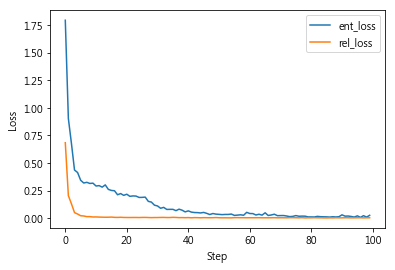

In [11]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.plot(all_ent_loss[:100], label='ent_loss')
plt.plot(all_rel_loss[:100], label='rel_loss')
plt.xlabel("Step")
plt.ylabel("Loss") 
plt.legend()
plt.show()

In [12]:
import random
def random_choose(input_var):
    r_choose = []
    for i in range(BATCH_SIZE):
        r_choose.append(random.randint(0,len(input_var)))
    return r_choose
        
def ent_argmax(output):
    output = output.view(BATCH_SIZE,MAX_LEN,ent_size).argmax(2)
    return output

def rel_argmax(output):
    output = output.view(BATCH_SIZE,MAX_LEN,MAX_LEN,rel_size).argmax(3)
    return output

In [13]:
# Check predictions after training
with torch.no_grad():
    r_choose = random_choose(input_var)
    model.eval()
    ent_output, rel_output = model(input_var[r_choose].cuda() if USE_CUDA else input_var)
    
    ent_loss = criterion_tag(ent_output.cpu(), ent_var[r_choose].view(BATCH_SIZE*MAX_LEN))
    ent_output = ent_argmax(ent_output)
    
    rel_loss = criterion_rel(rel_output.cpu(), rel_var[r_choose].view(BATCH_SIZE*MAX_LEN*MAX_LEN))
    
    
#     print('predict :', ent_output[0])
#     print('true :', ent_var[r_choose[0]])
    print()
    print('predict :', index2tag(ent_output[0], ix_to_ent_tag))
    print('true :', index2tag(ent_var[r_choose[0]], ix_to_ent_tag))
    print()
    print('===================================================')
    print()
    print()
    print('predict :', index2tag(ent_output[1], ix_to_ent_tag))
    print('true :', index2tag(ent_var[r_choose[1]], ix_to_ent_tag))
    
    print()
    print("Entity loss : %.4f" % ent_loss)
    print("Relation loss : %.4f" % rel_loss)


predict : ['B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
true : ['B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 

In [15]:
with torch.no_grad():
    r_choose = random_choose(input_dev)
    model.eval()
    ent_output, rel_output = model(input_dev[r_choose].cuda() if USE_CUDA else input_dev)
    
    ent_loss = criterion_tag(ent_output.cpu(), ent_dev[r_choose].view(BATCH_SIZE*MAX_LEN))
    ent_output = ent_argmax(ent_output)
    
    rel_loss = criterion_rel(rel_output.cpu(), rel_var[r_choose].view(BATCH_SIZE*MAX_LEN*MAX_LEN))
    
    print(r_choose[0])
    print()
    print('predict :', index2tag(ent_output[0], ix_to_ent_tag))
    print()
    print('true :', index2tag(ent_dev[r_choose[0]], ix_to_ent_tag))
    print()

    print("Entity loss : %.4f" % ent_loss)
    print("Relation loss : %.4f" % rel_loss)

22

predict : ['O', 'O', 'B-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']

true : ['O', 'O', 'B-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', '<PAD>', '<PAD>', '<PAD>',

In [23]:
with torch.no_grad():
    for step, (batch_x, batch_ent, batch_rel, batch_index) in enumerate(dev_loader):
        model.eval()
        ent_output, rel_output = model(batch_x.cuda() if USE_CUDA else batch_x)
        
        ent_loss = criterion_tag(ent_output.cpu(), batch_ent.view(BATCH_SIZE*MAX_LEN))
        ent_output = ent_argmax(ent_output)
        
        rel_loss = criterion_rel(rel_output.cpu(), rel_var[r_choose].view(BATCH_SIZE*MAX_LEN*MAX_LEN))
        rel_output = rel_argmax(rel_output)
    
        print()
        print('predict :', index2tag(ent_output[0], ix_to_ent_tag))
        print('true :', index2tag(batch_ent[0], ix_to_ent_tag))
        print()
        
        print("Entity loss : %.4f" % ent_loss)
        print("Relation loss : %.4f" % rel_loss)
        
        print()
        batch_decode(ent_output, rel_output, batch_index, raw_input_dev)


predict : ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
true : ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'B-FUNC

KeyError: 26

In [21]:
def batch_decode(ent_output, rel_output, batch_index, word_list):
    rel_lists = []
    for e,r,i in zip(ent_output, rel_output, batch_index):
        r_list = decode_rel(e, r)
        rel_lists.append(r_list)
        
        www = word_list[i]
        
        print(www)
        



def decode_rel(ent_output, rel_output):
    r_list = []
    r_dict = {}
    pred_ent = index2tag(ent_output, ix_to_ent_tag)
    
    e_loc = 0
    for loc, e in enumerate(pred_ent):
        if e[0]=='B':
            e_loc = loc
            r_dict[loc] = {
                '_2ndtag':e[2:],
            }
            r_list.append([])
            
        
        elif e[0]=='I':
            r_dict[e_loc]['end'] = loc
            r_list.append([])
            
        else:
            r_list.append("")
    
    
    IsB = False
    IsNext = False
    num_reocrd = -1
    now_loc = 0
    end_loc = 0
    tag = ""
    preAorB = ""
    nowAorB = ""
    pre_complete_rel = ""
    now_complete_rel = ""
    
    for now in range(len(rel_output)):
        for loc, rel in enumerate(rel_output[now][:now+1]):
            rel = rel.cpu().numpy()

            if rel!=rel_tag_to_ix[REL_NONE] and IsB==False and IsNext==False:

                IsB = True
                IsNext = True
                tag = ix_to_rel_tag[int(rel)]
                num_reocrd+=1
                
                now_loc = loc
                end_loc = r_dict[now_loc]['end']
                
                second_tag = r_dict[now_loc]['_2ndtag']
                preAorB = check_loc(second_tag)
                nowAorB = 'B' if preAorB=='A' else 'A'
                
                pre_complete_rel = tag+"-"+str(num_reocrd)+"-"+preAorB
                now_complete_rel = tag+"-"+str(num_reocrd)+"-"+nowAorB
                
                for token in range(now_loc, end_loc+1):
                    r_list[token].append(pre_complete_rel)
                
                r_list[now].append(now_complete_rel)

                
            elif rel!=rel_tag_to_ix[REL_NONE] and IsB:
                if loc<=end_loc:
                    pass
                else:
                    IsB = False
            
            elif rel!=rel_tag_to_ix[REL_NONE] and IsNext:
                r_list[now] = r_list[now-1]
                
            else:
                IsB = False

                
                
    return r_list
                

                
def check_loc(second_tag):
    if second_tag in rule[0]:
        return 'A'
    elif second_tag in rule[2]:
        return 'B'

In [18]:
decode_rel(ent_output[3], rel_output[3])

['',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 ['ApplyTo-0-A'],
 ['ApplyTo-0-A'],
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 ['ApplyTo-0-B'],
 ['ApplyTo-0-B'],
 ['ApplyTo-0-B'],
 ['ApplyTo-0-B'],
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '']

In [ ]:
ent_output[1]

In [50]:
dev_content = readfile(dev_data)
word_list, ent_list, rel_list = split_to_list(dev_content)
reserved_index = filter_len(word_list)
filter_word, filter_ent, filter_rel = filter_sentence(reserved_index, word_list, ent_list, rel_list)
input_padded, ent_padded, rel_padded = pad_all(filter_word, filter_ent, filter_rel)

In [51]:
word_list

[['以',
  '前',
  '我',
  '有',
  '敷',
  '過',
  '別',
  '款',
  '的',
  '美',
  '白',
  '面',
  '膜',
  '~',
  '很',
  '容',
  '易',
  '就',
  '會',
  '讓',
  '我',
  '的',
  '臉',
  '部',
  '肌',
  '膚',
  '過',
  '敏',
  '，',
  '會',
  '有',
  '紅',
  '紅',
  '的',
  '臉',
  '出',
  '現',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>'],
 ['每',
  '天',
  '都',
  '有',
  '認',
  '真',
  '使'

In [52]:
filter_word

[['以',
  '前',
  '我',
  '有',
  '敷',
  '過',
  '別',
  '款',
  '的',
  '美',
  '白',
  '面',
  '膜',
  '~',
  '很',
  '容',
  '易',
  '就',
  '會',
  '讓',
  '我',
  '的',
  '臉',
  '部',
  '肌',
  '膚',
  '過',
  '敏',
  '，',
  '會',
  '有',
  '紅',
  '紅',
  '的',
  '臉',
  '出',
  '現',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>'],
 ['使',
  '用',
  '了',
  '幾',
  '次',
  '，',
  '效'